In [1]:
import numpy as np
import mmh3
import os
import pandas as pd
import matplotlib.pyplot as plt

## Functions for minhash

In [2]:
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    
    all_shingles = []
    if delimiter != '':
        words_list = str(aString).split(delimiter)
    else:
        words_list = aString
    if len(words_list) < q:
        q = len(words_list)
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

def listhash(l,seed):
    val = 0
    for e in l:
        val = val ^ mmh3.hash(e, seed)
    return val 

def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = np.inf
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

def signature(df_reviews, q = 3, num_hashes = 100):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document idâ€™s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(df_reviews.index)
    counter = 1
    for ix, text in enumerate(df_reviews['Clean_Review']):
        #print(f'{counter}/{total_texts} - {ix} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[ix] = minhash_values
        counter += 1
    return dict_signatures

def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

def lsh(signatures_dict, jaccard_threshold=0.6, seed=42):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        print(i)
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
                    #print((list_keys[i], list_keys[j]))
                    #print(similar_items[(list_keys[i], list_keys[j])])
    return similar_items

## Import data

In [265]:
root = os.getcwd()
df = pd.read_csv(root + "\clean_sample_data_VG.csv")

In [266]:
df.head()

,overall,reviewText,Clean_Review
0,1.0,Won't work. No surprise. It's from the same gr...,work surprise group release stubbs zombie read...
1,1.0,Square proved that they didn't learn anything ...,square prove learn anything streak horrible fi...
2,1.0,Boring,boring
3,1.0,90% of gamers will only see the first 15% of t...,gamers see first game respawning never end bat...
4,1.0,"This Cute, Light mouse is definitely designed ...",cute light mouse definitely design moba game u...


## Create minhash signatures for each review

In [267]:
k = 100
b,r = 10, 10
assert k == b*r

sigs = signature(df, q = 1, num_hashes = k)

# sim_items = lsh(sigs)


KeyboardInterrupt: 

## Clustering based on minhash signatures

In [ ]:
def dic_to_vec(dic):
    """
    Create matrix of signatures usable by sklearn.
    
    args:
        dic: Dictionary of review signatures
    returns:
        numpy matrix of dimensions (# of reviews, # of minhashes)
    """
    for ix, sig in enumerate(list(dic.items())):
        if ix == 0:
            X = np.array([sig[1]])
        else:
            X = np.append(X,[sig[1]],axis=0)
    return X

In [ ]:
X = dic_to_vec(sigs)

In [8]:
y = np.array(df.overall.values)

## KMeans clustering

In [268]:
from sklearn.cluster import KMeans
#from sklearn.cluster import BisectingKMeans

In [269]:
# Initialize classifier
k_means = KMeans(n_clusters=5, random_state=0)

In [11]:
X_transform = k_means.fit_transform(X,y)

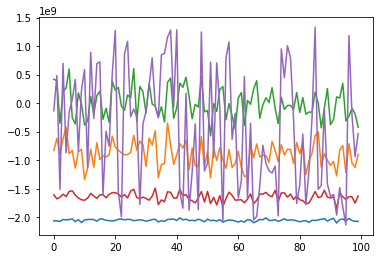

In [12]:
centroids = k_means.cluster_centers_

plt.plot(centroids.T)

In [13]:
def assign_cluster(centroid_list, dic):
    """
    Assigns each review to a cluster.
    
    Args:
        centroid_list: List of centroids in their vector format.
        dic: Dictionary of signatures of reviews.
    Returns:
        assignments: Dictionary of reviews and their cluster.
    """
    assignments = {}
    for ix, sig in enumerate(list(dic.items())):
        distances = []
        for j, centroid in enumerate(centroid_list):
            distances.append(np.linalg.norm(centroid-sig[1]))
        assignments[ix] = np.argmin(distances)
    return assignments

In [14]:
assigned = assign_cluster(centroids, sigs)

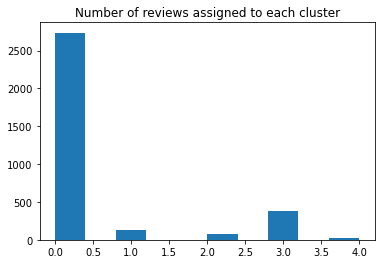

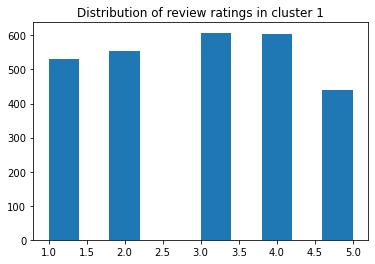

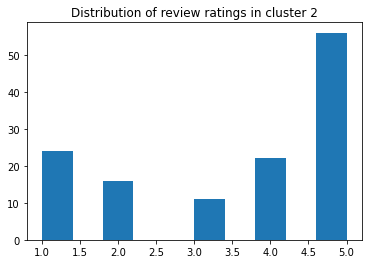

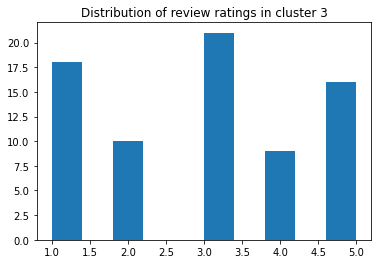

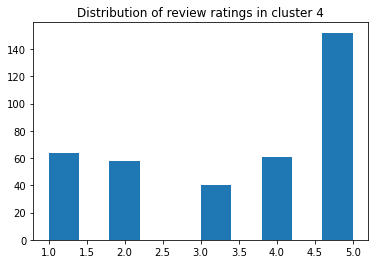

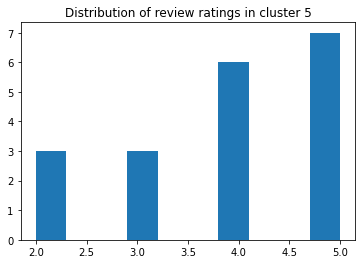

In [15]:
plt.hist(list(assigned.values()))
plt.title("Number of reviews assigned to each cluster")
plt.show()
for i in range(len(centroids)):
    df_slice = df.loc[pd.Series(list(assigned.values())) == i]
    #print(df_slice)
    #review_lengths = [len(df_slice.Clean_Review.values[i]) for i in range(len(df_slice.Clean_Review.values))]
    plt.hist(df_slice['overall'])
    plt.title(str("Distribution of review ratings in cluster "+ str(i+1)))
    plt.show()
    #plt.hist(review_lengths)
    #plt.show()

#### Subconclusion: Minhash vectorization does not result in meaningful clustering

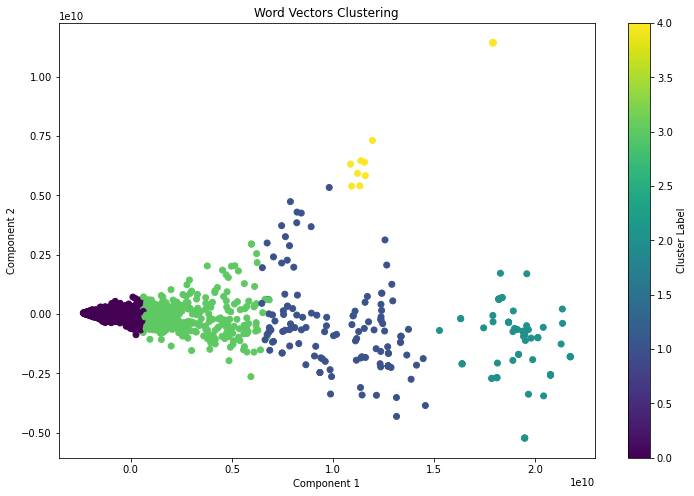

In [16]:
from sklearn.decomposition import PCA

labels = k_means.labels_

pca = PCA(n_components=4)
reduced_X = pca.fit_transform(X)
plt.figure(figsize=(12, 8))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('Word Vectors Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


## Defining basic tf_idf function

In [17]:
from collections import Counter

def get_word_usage(documents, n_t = None, min_appearances = 1):
    """ Called by tf_idf.
    Get number of document appearances for all words: """ 
    document_appearances = {}
    
    N = len(documents)
    
    for i in range(N):
        text = str(documents[i]).split(" ")
        unique_words = np.unique(text)
        for word in unique_words:
            if not(n_t is None) and n_t[word] < min_appearances:
                # If the word does not appear in enough documents to
                # be significant for the cluster in general.
                continue
            elif word not in document_appearances.keys():
                document_appearances[word] = 1
            else:
                document_appearances[word] = document_appearances[word] + 1
    return document_appearances, N

def calc_tf_idf(documents, N, n_t):
    tf_idf_sparse = []
    for i in range(N):
        text = str(documents[i]).split(" ")
        word_freq = Counter(text)
        max_freq = max(word_freq.values())
        
        tf_idf_vector = np.zeros(len(n_t))
        
        for word in word_freq.items():
            if word[0] in n_t.keys():
                index = list(n_t).index(word[0])
                tf_idf_vector[index] = word[1]/max_freq*np.log2(N/n_t[word[0]])
        
        tf_idf_sparse.append(tf_idf_vector)
    
    return np.asarray(tf_idf_sparse)


def get_tf_idf(df_docs):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t, N = get_word_usage(documents)

    tf_idf_sparse_matrix = calc_tf_idf(documents, N, n_t)
    
    return tf_idf_sparse_matrix, np.asarray(list(n_t.keys()))

In [18]:
tf_idf, features = get_tf_idf(df)

In [19]:
print(len(features))

12816


## TF_IDF for clusters

In [273]:
def merge_reviews(df, assignments):
    """ Collect all text from reviews in each cluster into a single string """
    assignments = np.asarray(list(assignments.values()))
    clusters = np.unique(assignments)
    documents = []
    for i in clusters:
        cluster_reviews = df.loc[assignments == i,"Clean_Review"].values
        all_text = str(cluster_reviews[0])
        for j in range(1, len(cluster_reviews)):
            all_text += " " + str(cluster_reviews[j])
        documents.append(all_text)
    
    return np.asarray(documents,str)

def get_tf_idf_cluster(df_docs, assignments, min_appearances = 1):
    documents = np.array(df_docs.Clean_Review.values)
    
    n_t_reviews, N = get_word_usage(documents)
    
    merged_documents = merge_reviews(df_docs, assignments)
    
    n_t_cluster, N = get_word_usage(merged_documents, n_t = n_t_reviews, min_appearances = min_appearances)
    
    tf_idf_sparse_matrix_clusters = calc_tf_idf(merged_documents, N, n_t_cluster)
    
    # Feature selection: Remove all features without weight in any class.
    key_mask = np.asarray(list(n_t_cluster.keys()))[tf_idf_sparse_matrix_clusters.sum(axis=0) > 0]
    array_mask = [word[0] in key_mask for word in n_t_cluster.items()]
    
    n_t_cluster = dict(filter(lambda x: x[0] in key_mask, n_t_cluster.items()))
    tf_idf_sparse_matrix_clusters = tf_idf_sparse_matrix_clusters[:,array_mask]
    
    tf_idf_sparse_matrix = calc_tf_idf(documents, len(documents), n_t_cluster)
    
    return tf_idf_sparse_matrix, tf_idf_sparse_matrix_clusters, n_t_cluster, n_t_reviews


def find_n_largest_tfidf(tf_idf, features, n=5):
    largest_tfidf = []
    for values in tf_idf:
        print(values)
        sort_values = np.argsort(values)[-n:][::-1]
        significant_words = np.asarray(list(features.keys()))[sort_values]
        largest_tfidf.append(significant_words)
    return largest_tfidf

## Supervised learning with tf_idf


In [270]:
df['Sentiment'] = df['overall'].copy()
df['Sentiment'].loc[(df['overall']<2.5)] = int(-1)
df['Sentiment'].loc[(df['overall']==3)] = int(0)
df['Sentiment'].loc[(df['overall']>3.5)] = int(1)

C:\Users\Frede\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [271]:
assignments = {}
for i in df.index:
    assignments[i] = (-1 if df.overall[i] < 2.5 else (1 if df.overall[i] > 3.5 else 0))
    #assignments[i] = (-1 if rating < 2.5 else 1)

In [ ]:
tf_idf, tf_idf_clusters, features, all_words = get_tf_idf_cluster(df, assignments, min_appearances = 2)

In [239]:
scores = [[sum(tf_idf[i]*tf_idf_clusters[j]*1000) for j in range(tf_idf_clusters.shape[0])] for i in range(tf_idf.shape[0])]

### Feature selection / dimensionality reduction

0

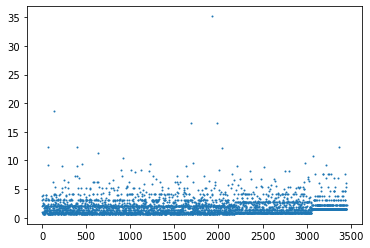

In [240]:
plt.scatter(np.arange(tf_idf_clusters.shape[1]),tf_idf_clusters.sum(axis=0)*1000,s=1)
np.sum(tf_idf_clusters.sum(axis=0) == 0)

## Clustering based on the tf-idf sparse matrix

In [241]:
X_train = np.asarray(scores)

In [262]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

#pca = TruncatedSVD(n_components=3)
#reduced_X = pca.fit_transform(X_train)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, init = "k-means++") #, n_init = 'auto')

y_train = np.asarray(df.overall.values)

kmeans.fit(X_train)

y_pred_train = kmeans.labels_

acc = accuracy_score(y_train, y_pred_train)

79
Centroids:  [12.24169705  8.92512405 63.27396578]
0.9746835443037974


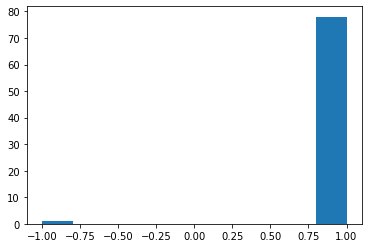

2028
Centroids:  [1.44086384 1.26002699 1.60047387]
0.16666666666666666


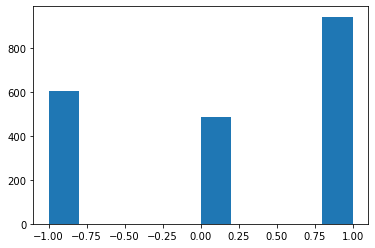

270
Centroids:  [ 5.80160692  5.17552147 23.35731595]
0.9481481481481482


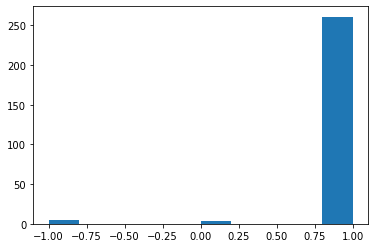

68
Centroids:  [80.18406109  7.09281633  7.15043663]
-1.0


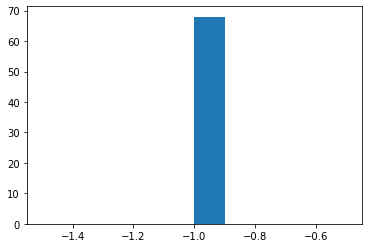

211
Centroids:  [39.06826927  4.19964363  6.58068943]
-0.9004739336492891


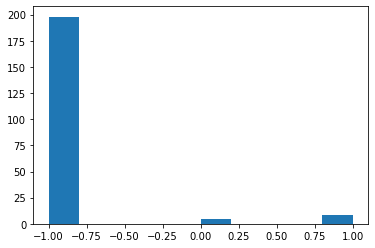

162
Centroids:  [ 5.52678322 24.23266267  6.12089529]
-0.006172839506172839


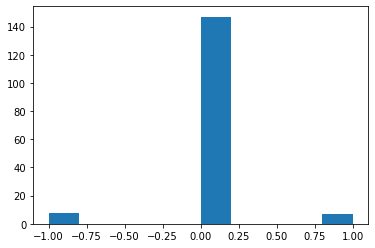

14
Centroids:  [  9.42248304   9.2566416  141.18950109]
1.0


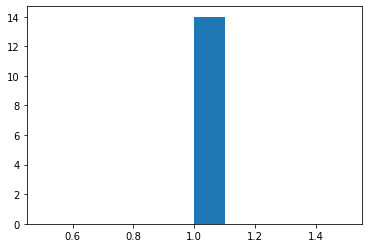

13
Centroids:  [150.67434837  19.75607191   9.89539029]
-1.0


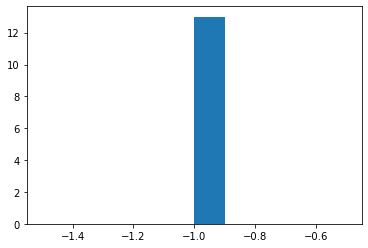

26
Centroids:  [27.47457607 90.50543807 15.42323778]
-0.19230769230769232


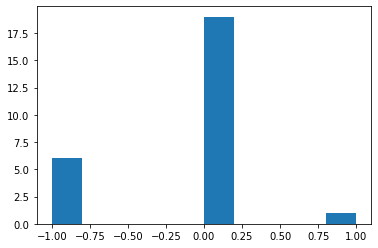

462
Centroids:  [16.50058953  2.72938021  3.77161561]
-0.6753246753246753


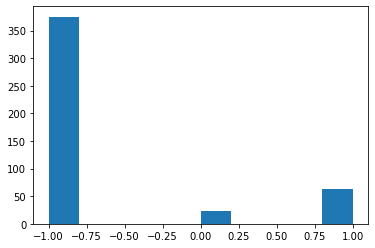

In [263]:
for i in range(n_clusters):
    print(np.sum(y_pred_train == i))
    print("Centroids: ", np.mean(X_train[y_pred_train == i],axis=0))
    avg_score = np.mean(df['Sentiment'].loc[y_pred_train == i].values)
    print(avg_score)
    plt.hist(df.loc[y_pred_train == i]['Sentiment'])
    plt.show()


In [ ]:
true_freq = Counter(y_train)
pred_freq = Counter(y_pred_train)
true_x = list(true_freq.keys())-0.1*np.ones(len(true_freq))
pred_x = list(pred_freq.keys())+0.1*np.ones(len(pred_freq))

plt.bar(true_x, true_freq.values(), width=0.2, label="True")
plt.bar(pred_x, list(pred_freq.values()), width=0.2, label="Pred")
plt.legend()
plt.show()

In [325]:
df.loc[y_pred_train == 2,'Clean_Review'].values

array(['involve computer year expert design program computer ton experience use computer world even think go online without protection virus long time user trend line product nothing best result use virus protection firewall protect threat trend micro bring new version program jump right feel need research product since trust company soon instal program regret firewall protection company say program enhances firewall available window operate system yet refuse give detail also many user trouble lose file get program allow know website recognize program version software give user less protection next control program decide want junk protecting attempt roll back old version program hour ordeal try get software uninstall windows uninstall program could get rid next try download uninstall tool directly trend micro work either purchase copy old version program right amazon since trend micro offer site copy force uninstall tool cd finally clean new version line stay far away program want best

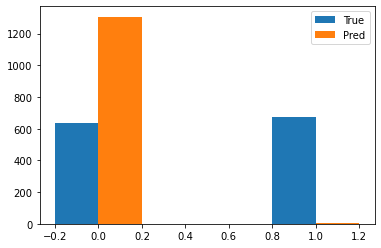

In [165]:
from collections import Counter



true_freq = Counter(y_train)
pred_freq = Counter(y_pred_train)
true_x = list(true_freq.keys())-0.1*np.ones(len(true_freq))
pred_x = list(pred_freq.keys())+0.1*np.ones(len(pred_freq))

plt.bar(true_x, true_freq.values(), width=0.2, label="True")
plt.bar(pred_x, list(pred_freq.values()), width=0.2, label="Pred")
plt.legend()
plt.show()